In [1]:
# Logistic Regression example with MNIST databse of handwritten digits using TensorFlow

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import timeit
import os

In [2]:
# Import mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# mnist dataset is divided among 3 categories: 'train', 'test', 'validation'.
# Get the number of examples from each of these categories
print(mnist.train.num_examples, mnist.test.num_examples, mnist.validation.num_examples)

# images are stored as: n_observations x n_features tensor (n-dim array)
# labels are stored as: n_observations x n_labels; each observation is a one-hot vector
print(mnist.train.images.shape, mnist.train.labels.shape)
print(mnist.validation.images.shape, mnist.validation.labels.shape)
print(mnist.test.images.shape, mnist.test.labels.shape)

55000 10000 5000
(55000, 784) (55000, 10)
(5000, 784) (5000, 10)
(10000, 784) (10000, 10)


In [4]:
# One-Hot encoded labels for the first 9 images in the test set
print(mnist.test.labels[0:9, :])

# classes (output features) are needed as single numbers for comparisions and performance measures
# convert the one-hot encoded vectors to a single number by taking the index of the highest element

mnist.test.cls = np.argmax(mnist.test.labels, axis=1)
print(mnist.test.cls[0:9])

mnist.validation.cls = np.argmax(mnist.validation.labels, axis=1)
print(mnist.validation.cls[0:9])

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
[7 2 1 0 4 1 4 9 5]
[5 0 4 1 9 2 1 3 1]


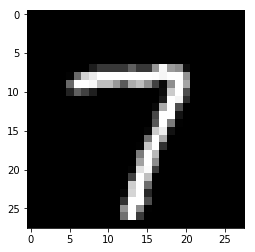

In [5]:
# Visualize any one of the images by reshaping it to a 28x28 image
plt.imshow(np.reshape(mnist.train.images[100, :], (28, 28)), cmap='gray')
plt.show()

## Data Dimensions

In [6]:
# Data Dimensions
img_size = 28

# store the images as one-dimensional arrays
img_size_flat = img_size * img_size

# No of input features
n_input = img_size_flat

# No of output features
n_output = 10

# tuple with height and width of images to reshape arrays
img_shape = (img_size, img_size)
print("Shape of the image:", img_shape)

Shape of the image: (28, 28)


## Define Placeholders for TensorFlow Graph

In [7]:
# Initialize placeholder for input
x = tf.placeholder(tf.float32, [None, n_input])

# Initialize placeholder for output
y_true = tf.placeholder(tf.float32, [None, n_output])

# Initialize placeholder for true class of each image in x
y_true_cls = tf.argmax(y_true, dimension=1)

In [8]:
# Set the weights and biases for the model
# W = tf.Variable(tf.random_normal([n_input, n_output], stddev=1.0), name='Weights')
# b = tf.Variable(tf.random_normal([n_output]), name='Biases')

In [9]:
W = tf.Variable(tf.zeros([n_input, n_output]), name='Weights')
b = tf.Variable(tf.zeros([n_output]), name='Biases')

## Training Parameters

In [10]:
# Initialize Parameters
# learning_rate is the step size
learning_rate = 0.01

batch_size = 128
# display_step = 1

## Construct the Linear Model

In [11]:
# Construct the model
# Use a simple regression equation (y = W * x + b) for softmax/output
logits = tf.matmul(x, W) + b

# since the value of the logits may be very small or large, normalize the values so that each row of the
# logits matrix sums to one, and each element is between zero and one. Use softmax function.
y_pred = tf.nn.softmax(logits=logits)

# calculate the predicted class from y_pred matrix by taking the index of the largest element in each row.
y_pred_cls = tf.argmax(y_pred, dimension=1)

## Loss, Optimization, and Accuracy

In [12]:
# Compute the loss using softmax_cross_entropy with logits activation function
# Find the average of the loss to guide the model's variables towards optimization
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits))

In [13]:
# produce the snapshot value of the loss everytime the summaries are written out
tf.summary.scalar('cost', loss)

<tf.Tensor 'cost:0' shape=() dtype=string>

In [14]:
# Initialize the optimization alogrithm
optimizer = tf.train.AdamOptimizer(learning_rate)

# Track each global step towards optimization
global_step = tf.Variable(0, name='global_step', trainable=False)

# Reduce the loss using GradientDescent Optimization
# and increment the global step counter as a single training step
optimizer = optimizer.minimize(loss, global_step=global_step)

In [15]:
# Compute the accuracy of the model

# Compare the true labels of the images to the predicted labels from the output
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# calculate the classification accuracy by type-casting the vector of booleans to floats (False=0, True=1), and
# then find the average
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Divide the Training, Validation, and Test Sets into Minibatches

In [16]:
n_train_batches = mnist.train.num_examples // batch_size
n_valid_batches = mnist.validation.num_examples // batch_size
n_test_batches = mnist.test.num_examples // batch_size

print("# of Training batches", n_train_batches)
print("# of Validation batches", n_valid_batches)
print("# of Test batches", n_test_batches)

# of Training batches 429
# of Validation batches 39
# of Test batches 78


## Initialize the TensorFlow Session

In [17]:
# Intialize all variables and Create TensorFlow session
init = tf.global_variables_initializer()
sess = tf.Session()

## Save the model

In [18]:
# Create a saver object to save all the variables of the neural network for storing and retrieving it later.

saver = tf.train.Saver()

# create a directory for saving the checkpoints that get written at regular intervals during optimization
save_dir = "checkpoints_mnist_linear/"
# create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# path for the checkpoint file
save_path = os.path.join(save_dir, "mnist_linear.ckpt")
if os.path.exists(save_path):
    print("Checkpoint created.")
else:
    print("No checkpoint exists as of now!!!!")

No checkpoint exists as of now!!!!


## Restore or Initialize Variables for TensorFlow Graph

In [19]:
# restore the latest checkpoint if available from the checkpoint directory
try:
    print("Trying to restore the latest checkpoint....")
    
    # search for the latest checkpoint
    last_ckpt_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    
    # load the data from the checkpoint file
    saver.restore(sess, save_path=last_ckpt_path)
    
    print("Checkpoint restored from: ", last_ckpt_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead...")
    sess.run(init)

Trying to restore the latest checkpoint....
Failed to restore checkpoint. Initializing variables instead...


## Helper Function to Perform Training

In [20]:
def optimize(n_epochs):
    
    finished = False
    curr_epoch = 0
    
    # start the timer
    start_time = timeit.default_timer()
    
    while (curr_epoch < n_epochs) and (not finished):
        
        # increment the no of iterations by 1
        curr_epoch += 1
        
        # get a batch of training examples
        # x_batch for images and y_batch for labels of these images
        x_batch, y_true_batch = mnist.train.next_batch(batch_size)
        
        # create a dictionary of above training batches that needs to be fed to the placeholder variables
        # y_true_cls is not set as it is not used during training
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        
        for minibatch_i in range(n_train_batches):
            
            # iteration number
            iter = (curr_epoch - 1) * n_train_batches + minibatch_i
            
            if ((iter + 1) % n_train_batches == 0):
        
                # run the optimizer using the batch of training data
                # retrieve the global step counter
                global_step_, optimizer_, cost_ = sess.run([global_step, optimizer, loss], 
                                                           feed_dict=feed_dict_train)
            
                # calculate the accuracy of the training set.
                train_accuracy = sess.run(accuracy, feed_dict=feed_dict_train)

                # calculate the accuracy of the validation set.
                valid_accuracy, _ = validation_accuracy()
                
                epoch_msg = ("Epoch %i, Minibatch %i/%i ") % (curr_epoch, minibatch_i+1, n_train_batches)
                print(epoch_msg)

                # print the accuracy message
                output = "Training Accuracy: {0:>6.1%}, Validation Accuracy: {1:>6.1%}"
                print(output.format(train_accuracy, valid_accuracy))
            
#                 print("Training Cost: ", cost_)
                
                
                # save all variables to a checkpoint and append the total_interations counter to the filename
                saver.save(sess, save_path=save_path, global_step=global_step_)
                print("Checkpoint Saved...")
                
                print("=====================================================================")
                print("=====================================================================")
        
    # end the timer
    end_time = timeit.default_timer()
        
    # total time taken to perform the iterations
    time_diff = end_time - start_time
    
    print(("Training Accuracy %f %%, Validation Accuracy %f %%") % (train_accuracy, valid_accuracy))

    print("The code ran for %.1fs" % (time_diff))
    
    print("The code ran for %.2fm" % (time_diff / 60.))

## Helper Function to Plot Images

In [21]:
# Helper funciton to plot images
# plot 9 images in a 3x3 grid, and print the true and predicted classes below each image
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

## Plot few images to check if the images and their corresponding labels are correct

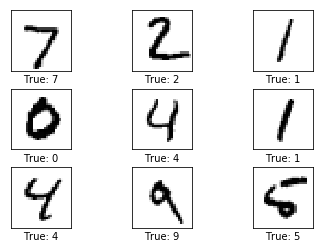

In [22]:
# get the first 10 images from the test-set
images = mnist.test.images[0:9]

# get the true classes for those images
cls_true = mnist.test.cls[0:9]

# plot the images and the labels using the plot helper function
plot_images(images=images, cls_true=cls_true)

## Helper function to plot example errors

In [23]:
# Function for plotting examples of images from the test-set that have been misclassified
def plot_examples_errors(cls_pred, correct):
    
    # negate the boolean array
    incorrect = (correct == False)
    
    # get the images from the test-set that have been incorrectly classified
    images = mnist.test.images[incorrect]
    
    # get the predicted class for the above incorrectly classified images
    cls_pred = cls_pred[incorrect]
    
    # get the true class for the above images
    cls_true = mnist.test.cls[incorrect]
    
    # plot the first 9 images
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

## Helper function to plot confusion matrix

In [24]:
def plot_confusion_matrix(cls_pred):
    
    # get the true classifications for the test-set
    cls_true = mnist.test.cls
    
    # create a dictionary of test examples
    feed_dict_test = {x: mnist.test.images, y_true: mnist.test.labels, y_true_cls: cls_true}
    
    # cls_pred is an array of the predicted class number for all images in the test-set
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)
    
    # get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    # print the confusion matrix as text
    for i in range(n_output):
        # append the appropriate label to each line
        label_name = "({}) {}".format(i, mnist.test.cls[i])
        print(cm[i, :], label_name)
    
    # plot the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    # adjust the plot
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(n_output)
    plt.xticks(tick_marks, range(n_output))
    plt.yticks(tick_marks, range(n_output))
    plt.xlabel('Predicted')
    plt.ylabel('True')

## Helper Functions to Predict the Classifications

In [25]:
def predict_cls(images, labels, cls_true):
    
    # no of images
    num_images = len(images)
    
    # allocate an array for the predicted classes which will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    # calculate the predicted classes for the batches by iterating through all the batches
    
    # starting index (i) for the next batch
    i = 0
    
    while i < num_images:
        # ending index (j) for the next batch
        j = min(i + batch_size, num_images)
        
        # create a feed-dict with the images and labels between index i and j
        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        
        # calculate the predicted class using TensorFlow
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)
        
        # set the start-index of the next batch to the end-index of the current batch
        i = j
        
    # create a boolean array to check whether each image is correctly classified
    correct = (cls_true == cls_pred)
    label_names = mnist.test.labels
    return correct, cls_pred

In [26]:
# calculate predicted class for the test-set and validation-set

def predict_cls_test():
    return predict_cls(images = mnist.test.images, labels = mnist.test.labels, cls_true = mnist.test.cls)

def predict_cls_validation():
    return predict_cls(images = mnist.validation.images, labels = mnist.validation.labels, 
                       cls_true = mnist.validation.cls)

## Helper Functions to calculate the Classification Accuracy

In [27]:
# Define a helper function to calculates the classification accuracy given a boolean array to check if each image 
# was correctly classified.
# e.g: cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4

def cls_accuracy(correct):
    # calculate the no of correctly classified images.
    # 0 = False, 1 = True
    correct_sum = correct.sum()
    
    # classification accuracy = no of correctly classified images / total no of images in the given dataset
    cls_accuracy = float(correct_sum) / len(correct)
    
    return cls_accuracy, correct_sum

In [28]:
# Define a function to find the classification accuracy on the validation set
def validation_accuracy():
    correct, _ = predict_cls_validation()
    
    return cls_accuracy(correct)

In [29]:
# Define a function to print the classification accuracy on the test-set

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    
    # for all the images in the test-set, calculate the predicted class and check if they are correct
    correct, cls_pred = predict_cls_test()
    
    # classification accuracy and the no of correct classifications
    test_accuracy, num_correct = cls_accuracy(correct)
    
    # no of images being classified
    num_images = len(correct)
    
    
    # print the accuracy
    msg = "Test-Set Accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(test_accuracy, num_correct, num_images))
    
    # plot some examples of misclassifications
    if show_example_errors:
        print("Example errors:")
        plot_examples_errors(cls_pred=cls_pred, correct=correct)
        
    # plot the confusion matrix
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Helper Function to Plot the Weights

In [30]:
def plot_weights(weights, cmap):
    # get the values of the weights from the tensorflow variable
    w = sess.run(weights)
    
    # print statistics for the weights
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # get the lowest and the highest values for the weights in order to correct the color intensity
    # across the images to compare them with each other
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))
    
    # create figure with 3x4 sub-plots where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # only use the weights for the first 10 sub-plots
        if i < 10:
            # get the weights for the ith digit and reshape it.
            # w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)
            
            # set the label for the sub-plot
            ax.set_xlabel("Weights: {0}".format(i))
            
            # plot the image
            ax.imshow(image, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap=cmap)
            
        # remove ticks from each sub-plot
        ax.set_xticks([])
        ax.set_yticks([])
    
#     # display the plot
#     plt.show()

## Perform Training

### Performance of the model before any optimization

In [31]:
print("Accuracy of the model before training")
print_test_accuracy()

Accuracy of the model before training
Test-Set Accuracy: 9.8% (980 / 10000)


## Performance of the Model after 500 epochs using Adam Optimizer

In [32]:
print("Starting Training Operation with a batch size of", batch_size)
optimize(n_epochs=500)

Starting Training Operation with a batch size of 128
Epoch 1, Minibatch 429/429 
Training Accuracy:  60.9%, Validation Accuracy:  46.0%
Checkpoint Saved...
Epoch 2, Minibatch 429/429 
Training Accuracy:  61.7%, Validation Accuracy:  62.3%
Checkpoint Saved...
Epoch 3, Minibatch 429/429 
Training Accuracy:  72.7%, Validation Accuracy:  69.0%
Checkpoint Saved...
Epoch 4, Minibatch 429/429 
Training Accuracy:  75.8%, Validation Accuracy:  69.3%
Checkpoint Saved...
Epoch 5, Minibatch 429/429 
Training Accuracy:  75.8%, Validation Accuracy:  70.1%
Checkpoint Saved...
Epoch 6, Minibatch 429/429 
Training Accuracy:  78.1%, Validation Accuracy:  71.6%
Checkpoint Saved...
Epoch 7, Minibatch 429/429 
Training Accuracy:  83.6%, Validation Accuracy:  72.4%
Checkpoint Saved...
Epoch 8, Minibatch 429/429 
Training Accuracy:  83.6%, Validation Accuracy:  74.5%
Checkpoint Saved...
Epoch 9, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  77.3%
Checkpoint Saved...
Epoch 10, Minibatch 

Checkpoint Saved...
Epoch 37, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  87.8%
Checkpoint Saved...
Epoch 38, Minibatch 429/429 
Training Accuracy:  85.9%, Validation Accuracy:  88.2%
Checkpoint Saved...
Epoch 39, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  88.5%
Checkpoint Saved...
Epoch 40, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  88.5%
Checkpoint Saved...
Epoch 41, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  88.4%
Checkpoint Saved...
Epoch 42, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  88.3%
Checkpoint Saved...
Epoch 43, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  88.2%
Checkpoint Saved...
Epoch 44, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  88.3%
Checkpoint Saved...
Epoch 45, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  88.6%
Checkpoint Saved...
Epoch 46, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 72, Minibatch 429/429 
Training Accuracy:  86.7%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 73, Minibatch 429/429 
Training Accuracy:  83.6%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 74, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  89.6%
Checkpoint Saved...
Epoch 75, Minibatch 429/429 
Training Accuracy:  85.2%, Validation Accuracy:  89.7%
Checkpoint Saved...
Epoch 76, Minibatch 429/429 
Training Accuracy:  80.5%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 77, Minibatch 429/429 
Training Accuracy:  78.9%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 78, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 79, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 80, Minibatch 429/429 
Training Accuracy:  87.5%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 81, Minibatch 429/429 
Training Accura

Checkpoint Saved...
Epoch 106, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 107, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 108, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  90.3%
Checkpoint Saved...
Epoch 109, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 110, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 111, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  90.0%
Checkpoint Saved...
Epoch 112, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 113, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 114, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  90.1%
Checkpoint Saved...
Epoch 115, Minibatch 429/429 
Train

Epoch 139, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 140, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 141, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 142, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 143, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 144, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 145, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 146, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 147, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 148, Minibatch 429/429 
Training Accuracy:  91.4%

Checkpoint Saved...
Epoch 174, Minibatch 429/429 
Training Accuracy:  86.7%, Validation Accuracy:  90.2%
Checkpoint Saved...
Epoch 175, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  89.8%
Checkpoint Saved...
Epoch 176, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  89.5%
Checkpoint Saved...
Epoch 177, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  89.5%
Checkpoint Saved...
Epoch 178, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  89.9%
Checkpoint Saved...
Epoch 179, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  90.5%
Checkpoint Saved...
Epoch 180, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  90.8%
Checkpoint Saved...
Epoch 181, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  90.8%
Checkpoint Saved...
Epoch 182, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 183, Minibatch 429/429 
Train

Checkpoint Saved...
Epoch 209, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 210, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 211, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 212, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 213, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 214, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 215, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 216, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 217, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  90.6%
Checkpoint Saved...
Epoch 218, Minibatch 429/429 
Train

Epoch 243, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 244, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 245, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 246, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 247, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 248, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 249, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 250, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 251, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  90.7%
Checkpoint Saved...
Epoch 252, Minibatch 429/429 
Training Accuracy:  87.5%

Epoch 278, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 279, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 280, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.1%
Checkpoint Saved...
Epoch 281, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  91.0%
Checkpoint Saved...
Epoch 282, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  90.9%
Checkpoint Saved...
Epoch 283, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 284, Minibatch 429/429 
Training Accuracy:  85.9%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 285, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 286, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 287, Minibatch 429/429 
Training Accuracy:  93.8%

Checkpoint Saved...
Epoch 313, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 314, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 315, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 316, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 317, Minibatch 429/429 
Training Accuracy:  86.7%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 318, Minibatch 429/429 
Training Accuracy:  85.9%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 319, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 320, Minibatch 429/429 
Training Accuracy:  87.5%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 321, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 322, Minibatch 429/429 
Train

Checkpoint Saved...
Epoch 348, Minibatch 429/429 
Training Accuracy:  82.8%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 349, Minibatch 429/429 
Training Accuracy:  87.5%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 350, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 351, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 352, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 353, Minibatch 429/429 
Training Accuracy:  89.1%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 354, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 355, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 356, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 357, Minibatch 429/429 
Train

Epoch 382, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 383, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  91.6%
Checkpoint Saved...
Epoch 384, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 385, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  91.7%
Checkpoint Saved...
Epoch 386, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  91.8%
Checkpoint Saved...
Epoch 387, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 388, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 389, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  92.0%
Checkpoint Saved...
Epoch 390, Minibatch 429/429 
Training Accuracy:  83.6%, Validation Accuracy:  91.9%
Checkpoint Saved...
Epoch 391, Minibatch 429/429 
Training Accuracy:  89.1%

Epoch 417, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 418, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 419, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 420, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 421, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  91.4%
Checkpoint Saved...
Epoch 422, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 423, Minibatch 429/429 
Training Accuracy:  99.2%, Validation Accuracy:  91.3%
Checkpoint Saved...
Epoch 424, Minibatch 429/429 
Training Accuracy:  97.7%, Validation Accuracy:  91.2%
Checkpoint Saved...
Epoch 425, Minibatch 429/429 
Training Accuracy:  87.5%, Validation Accuracy:  91.5%
Checkpoint Saved...
Epoch 426, Minibatch 429/429 
Training Accuracy:  92.2%

Checkpoint Saved...
Epoch 452, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  92.4%
Checkpoint Saved...
Epoch 453, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 454, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 455, Minibatch 429/429 
Training Accuracy:  94.5%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 456, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 457, Minibatch 429/429 
Training Accuracy:  96.9%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 458, Minibatch 429/429 
Training Accuracy:  91.4%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 459, Minibatch 429/429 
Training Accuracy:  89.8%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 460, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 461, Minibatch 429/429 
Train

Epoch 486, Minibatch 429/429 
Training Accuracy:  96.1%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 487, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 488, Minibatch 429/429 
Training Accuracy:  92.2%, Validation Accuracy:  92.4%
Checkpoint Saved...
Epoch 489, Minibatch 429/429 
Training Accuracy:  88.3%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 490, Minibatch 429/429 
Training Accuracy:  84.4%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 491, Minibatch 429/429 
Training Accuracy:  95.3%, Validation Accuracy:  92.3%
Checkpoint Saved...
Epoch 492, Minibatch 429/429 
Training Accuracy:  90.6%, Validation Accuracy:  92.2%
Checkpoint Saved...
Epoch 493, Minibatch 429/429 
Training Accuracy:  93.0%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 494, Minibatch 429/429 
Training Accuracy:  93.8%, Validation Accuracy:  92.1%
Checkpoint Saved...
Epoch 495, Minibatch 429/429 
Training Accuracy:  93.8%

Test-Set Accuracy: 91.7% (9174 / 10000)
Example errors:


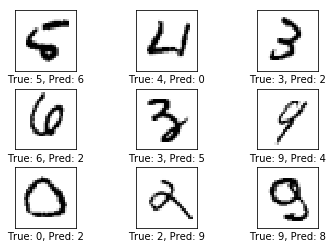

In [33]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=False)

Test-Set Accuracy: 91.7% (9174 / 10000)
Confusion Matrix:
[939   0   7   2   1  12  10   2   6   1] (0) 7
[   0 1078    3    3    0    1    4    2   44    0] (1) 2
[  4   6 928   5   5   5  12   8  54   5] (2) 1
[  1   0  30 879   0  52   3   7  28  10] (3) 0
[  2   1   8   1 896   0  14   3  12  45] (4) 4
[  7   1   3  18   5 799  12   4  37   6] (5) 1
[  6   3   9   0   7  20 907   1   5   0] (6) 4
[  2   4  30   5   7   0   0 927   8  45] (7) 9
[  4   2   6  17   7  24   9   5 894   6] (8) 5
[  7   4   2   9  19  10   0  14  17 927] (9) 9


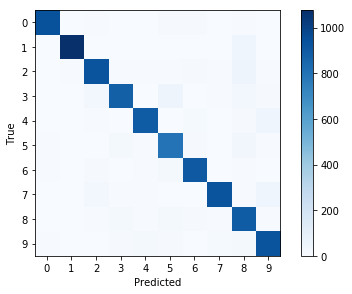

In [34]:
print_test_accuracy(show_example_errors=False, show_confusion_matrix=True)

### Plot the Weights

Min:  -1.19690, Max:   1.04886
Mean: -0.09635, Stdev: 0.24950


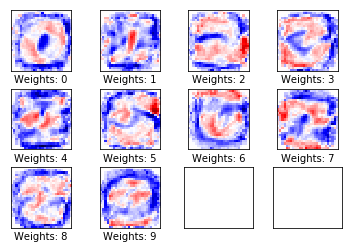

In [35]:
plot_weights(weights=W, cmap='seismic')

### Close the Session

In [36]:
# sess.close()